# Time series of key diagnostics of the THAI simulations


In [1]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [2]:
# Data analysis and viz libraries
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.offsetbox import AnchoredText

# Progress bar
from tqdm.notebook import tqdm

In [3]:
import aeolus.plot as aplt

In [4]:
# Local modules
import mypaths
from calc import get_time_rel_days, time_mean
from commons import MODELS
from names import names
from plot_func import KW_AUX_TTL, KW_MAIN_TTL, KW_SBPLT_LABEL, figsave

In [5]:
plt.style.use("paper.mplstyle")


Bad key legend.labelcolor in file paper.mplstyle, line 10 ('legend.labelcolor : linecolor')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution


## Choose cases

In [6]:
THAI_cases = ["Hab1", "Hab2"]

## Load the data

Load the data previously preprocessed: spatially averaged time series.

In [7]:
# Load data
datasets = {}  # Create an empty dictionary to store all data
# for each of the THAI cases, create a nested directory for models
for THAI_case in THAI_cases:
    datasets[THAI_case] = {}
    for model_key in MODELS.keys():
        datasets[THAI_case][model_key] = xr.open_dataset(
            mypaths.datadir / model_key / f"{THAI_case}_time_series_{model_key}.nc"
        )

In [8]:
# SIMULATION LENGTH [Earth days]
ndays = 610

## Choose case

In [9]:
AGGR_TITLES = {
    "g": "Global",
    "d": "Day side",
    "n": "Night side",
    "t": "Terminators",
}

In [10]:
VAR_PLOT = {
    "t_sfc": {
        "title": "Surface\ntemperature [$K$]",
        "lim": {
            "Hab1": dict(g=[230, 255], d=[258, 272], n=[200, 240]),
            "Hab2": dict(g=[265, 300], d=[280, 305], n=[255, 290]),
        },
    },
    "ocean_frac": {
        "title": "Ice-free ocean\narea fraction",
        "lim": {"Hab1": dict(g=[0.18, 0.25]), "Hab2": dict(g=[0.3, 1.1])},
    },
    "cwp": {
        "title": "Cloud water\npath [$kg$ $m^{-2}$]",
        "lim": {
            "Hab1": dict(g=[0.02, 0.18], d=[0.04, 0.30], n=[0, 0.12], t=[0, 0.18]),
            "Hab2": dict(g=[0.02, 0.3], d=[0.04, 0.4], n=[0, 0.25], t=[0, 0.25]),
        },
    },
    "alt_cld_mmr_max": {
        "title": "Altitude of the cloud\nMMR maximum [$km$]",
        "lim": {
            "Hab1": dict(g=[0, 12], d=[0, 12], n=[0, 12], t=[0, 12]),
            "Hab2": dict(g=[0, 15], d=[0, 15], n=[0, 15], t=[0, 15]),
        },
    },
}

Saved to ../plots/Hab1__tseries__t_sfc_ocean_frac_cwp_alt_cld_mmr_max__roll_mean.png
Saved to ../plots/Hab2__tseries__t_sfc_ocean_frac_cwp_alt_cld_mmr_max__roll_mean.png


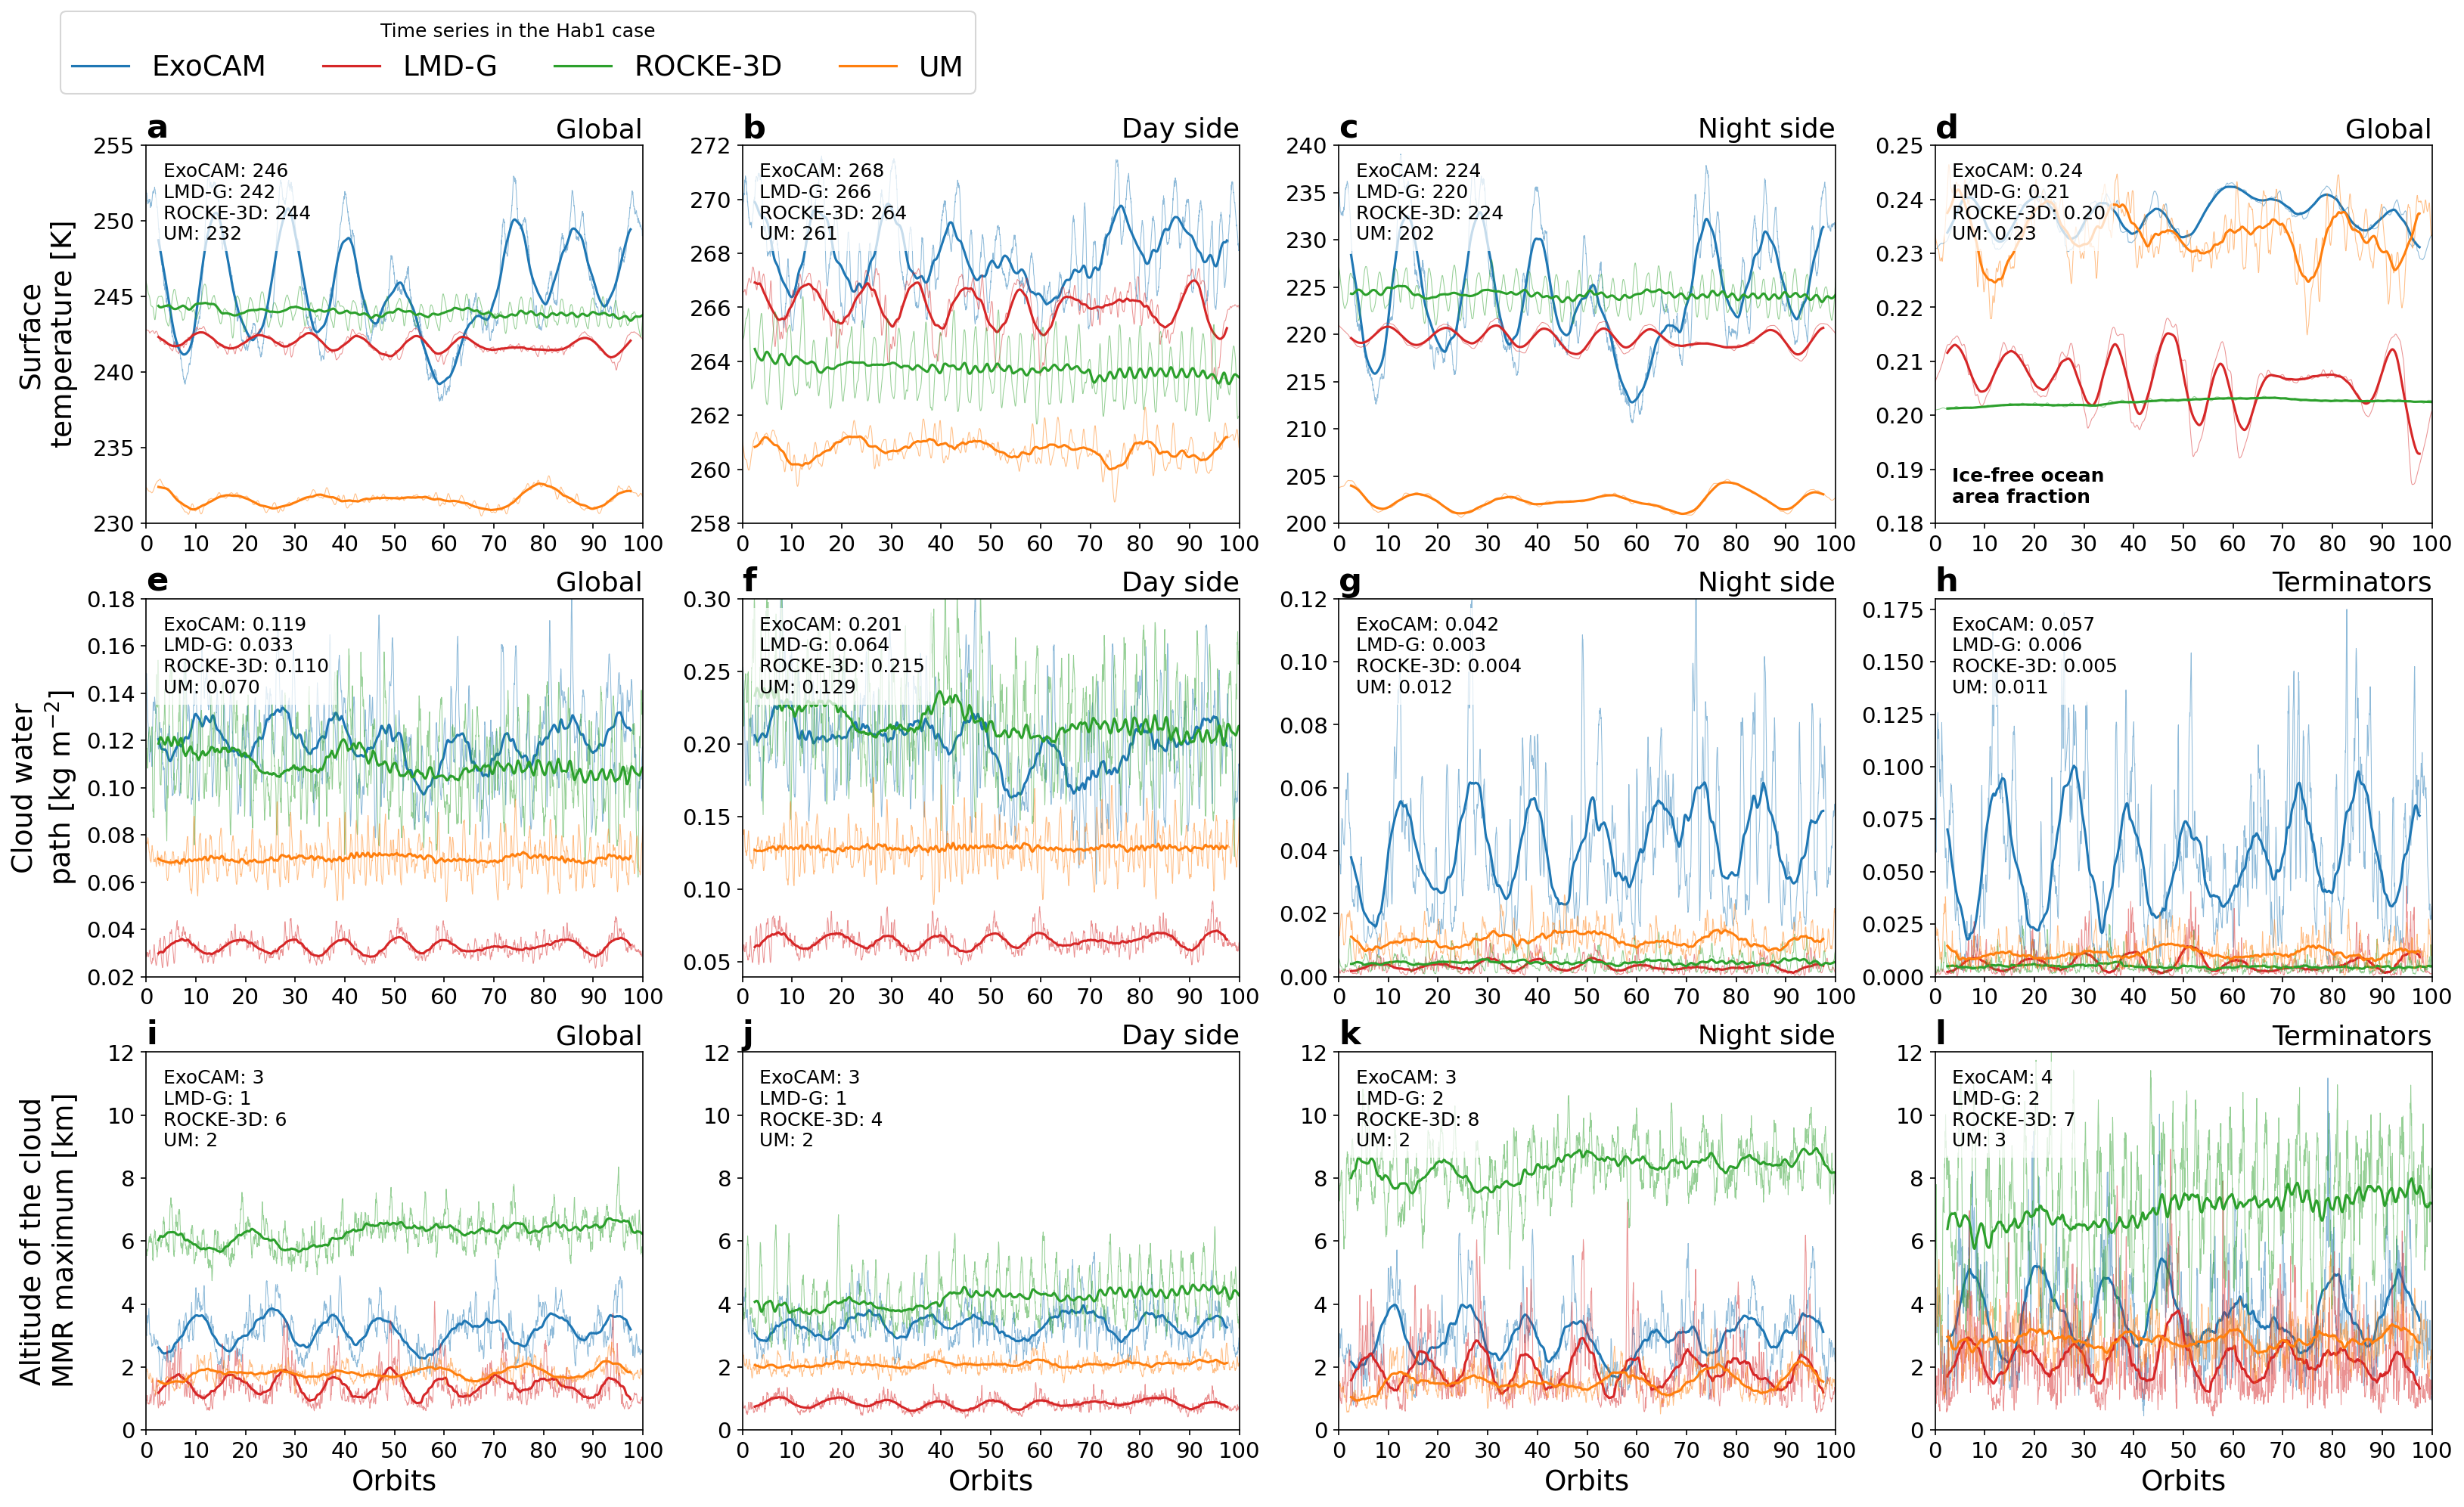

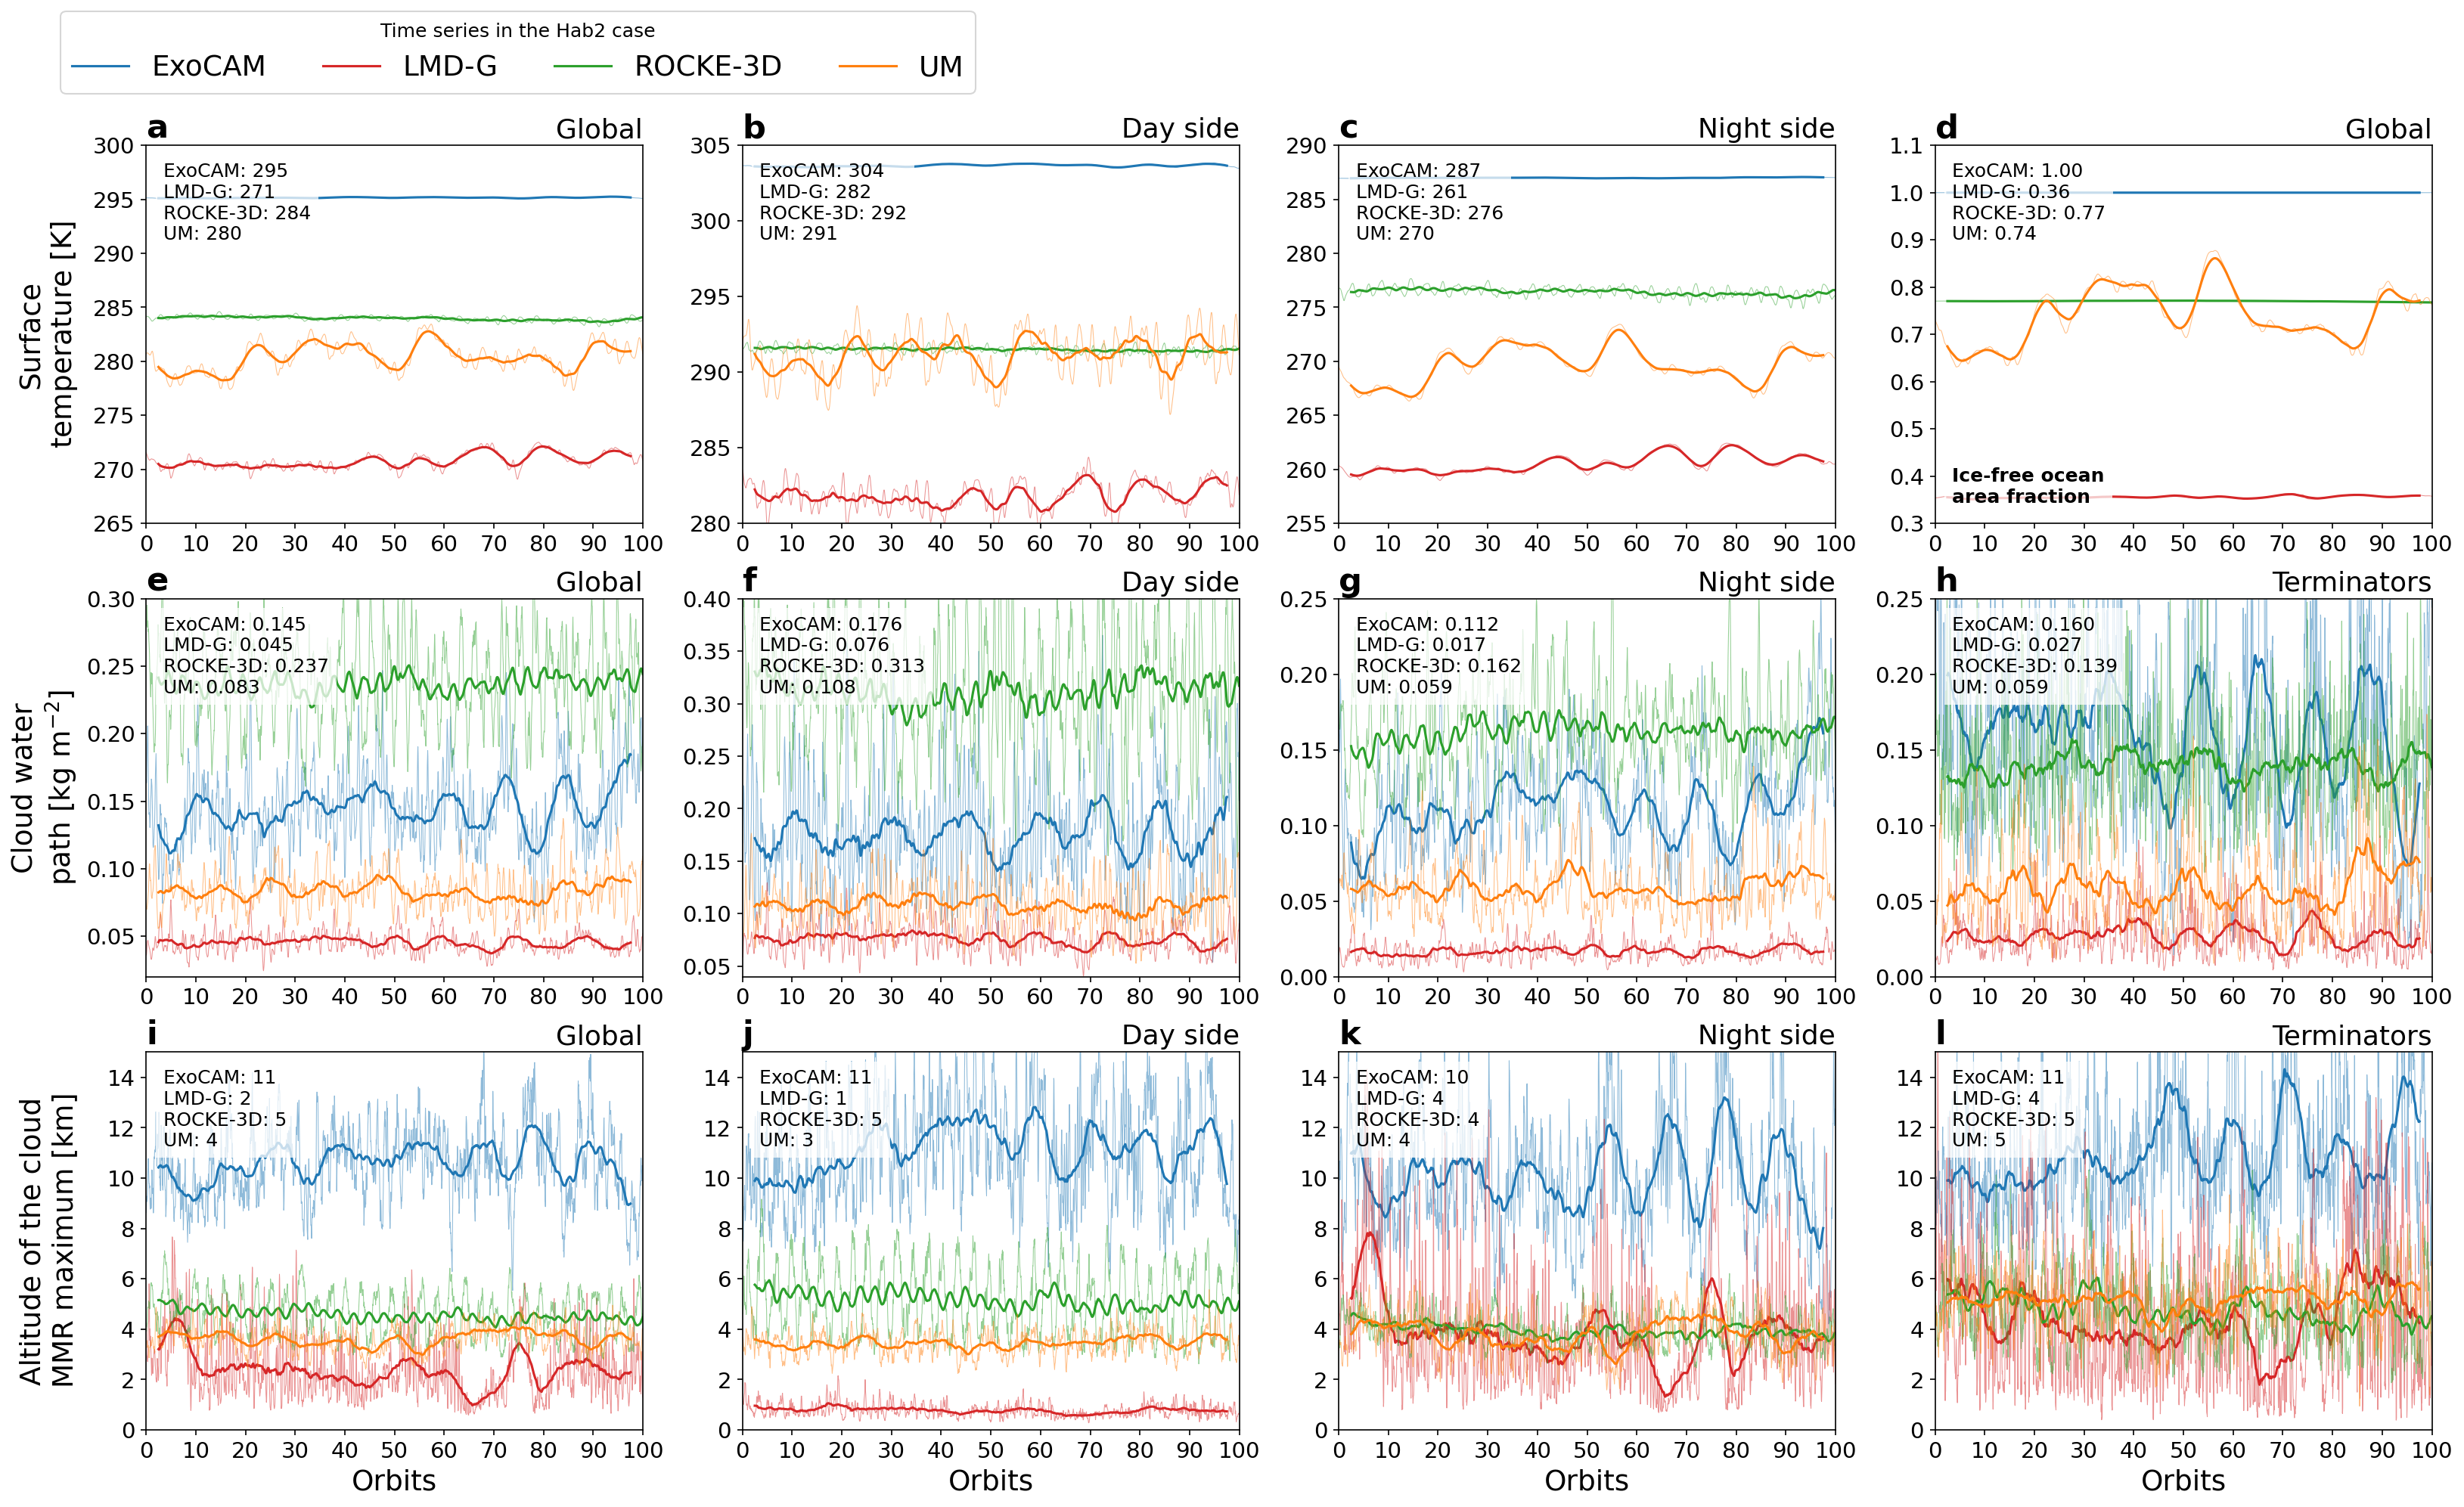

In [11]:
use_roll_mean = True
ncols = 4
nrows = 3  # len(VAR_PLOT)
rolling_window = 122  # 4 x 6.1 x 5 = 5 TRAPPIST-1e days

for THAI_case in THAI_cases:
    if THAI_case.endswith("1"):
        import const_ben1_hab1 as const
    else:
        import const_ben2_hab2 as const

    fig, axs = plt.subplots(
        ncols=ncols, nrows=nrows, figsize=(6.5 * ncols, 5 * nrows), constrained_layout=False
    )
    iletters = aplt.subplot_label_generator()
    # Surface temperature
    ax_slice = axs[0, :-1]
    var_key = "t_sfc"
    var_dict = VAR_PLOT[var_key]
    for ax, (aggr_key, aggr_title) in zip(ax_slice, AGGR_TITLES.items()):
        t_mean_str = {}
        for model_key, model_dict in MODELS.items():
            model_names = names[model_key]
            data = datasets[THAI_case][model_key][f"{var_key}_{aggr_key}"]
            time = np.arange(data.shape[0]) / 4
            t_mean_str[model_dict["title"]] = time_mean(data, time_name=model_names.t)
            if use_roll_mean:
                ax.plot(time, data, color=model_dict["color"], linewidth=0.5, alpha=0.5)
                ax.plot(
                    time,
                    data.rolling(**{model_names.t: rolling_window}, center=True).mean(),
                    color=model_dict["color"],
                    linewidth=1.5,
                    label=model_dict["title"],
                )
            else:
                ax.plot(
                    time,
                    data,
                    color=model_dict["color"],
                    linewidth=1.0,
                    label=model_dict["title"],
                )
        t_mean_str = "\n".join(
            [f"{k}: {round(float(v.values)):.0f}" for k, v in t_mean_str.items()]
        )
        at = AnchoredText(t_mean_str, loc="upper left")
        at.patch.set_facecolor((1, 1, 1, 0.75))
        at.patch.set_edgecolor("none")
        ax.add_artist(at)
        ax.set_ylim(var_dict["lim"][THAI_case][aggr_key])
        if ax.is_first_col():
            ax.set_ylabel(var_dict["title"])
        ax.set_title(aggr_title, **KW_AUX_TTL)

    # Ocean fraction (global only)
    var_key = "ocean_frac"
    var_dict = VAR_PLOT[var_key]
    aggr_key = "g"
    ax = axs[0, -1]
    t_mean_str = {}
    for model_key, model_dict in MODELS.items():
        model_names = names[model_key]
        data = datasets[THAI_case][model_key][f"{var_key}_{aggr_key}"]
        time = np.arange(data.shape[0]) / 4
        t_mean_str[model_dict["title"]] = time_mean(data, time_name=model_names.t)
        if use_roll_mean:
            ax.plot(time, data, color=model_dict["color"], linewidth=0.5, alpha=0.5)
            ax.plot(
                time,
                data.rolling(**{model_names.t: rolling_window}, center=True).mean(),
                color=model_dict["color"],
                linewidth=1.5,
                label=model_dict["title"],
            )
        else:
            ax.plot(
                time,
                data,
                color=model_dict["color"],
                linewidth=1.0,
                label=model_dict["title"],
            )
    t_mean_str = "\n".join([f"{k}: {float(v.values):.2f}" for k, v in t_mean_str.items()])
    at = AnchoredText(t_mean_str, loc="upper left")
    at.patch.set_facecolor((1, 1, 1, 0.75))
    at.patch.set_edgecolor("none")
    ax.add_artist(at)
    at = AnchoredText(var_dict["title"], loc="lower left", prop=dict(fontweight="bold"))
    at.patch.set_facecolor((1, 1, 1, 0.75))
    at.patch.set_edgecolor("none")
    ax.add_artist(at)
    # ax.set_title(var_dict["title"], **KW_MAIN_TTL)
    ax.set_ylim(var_dict["lim"][THAI_case][aggr_key])
    ax.set_title(AGGR_TITLES[aggr_key], **KW_AUX_TTL)

    # The rest: CWP and cloud height
    for ax_slice, var_key in zip(axs[1:, :], ["cwp", "alt_cld_mmr_max"]):
        var_dict = VAR_PLOT[var_key]
        if var_key == "alt_cld_mmr_max":
            factor = 1 / const.kilo
        else:
            factor = 1
        for ax, (aggr_key, aggr_title) in zip(ax_slice, AGGR_TITLES.items()):
            t_mean_str = {}
            for model_key, model_dict in MODELS.items():
                model_names = names[model_key]
                data = datasets[THAI_case][model_key][f"{var_key}_{aggr_key}"]
                data = data.copy() * factor
                time = np.arange(data.shape[0]) / 4
                t_mean_str[model_dict["title"]] = time_mean(data, time_name=model_names.t)
                if use_roll_mean:
                    ax.plot(time, data, color=model_dict["color"], linewidth=0.5, alpha=0.5)
                    ax.plot(
                        time,
                        data.rolling(**{model_names.t: rolling_window}, center=True).mean(),
                        color=model_dict["color"],
                        linewidth=1.5,
                        label=model_dict["title"],
                    )
                else:
                    ax.plot(
                        time,
                        data,
                        color=model_dict["color"],
                        linewidth=1.0,
                        label=model_dict["title"],
                    )
            if var_key == "cwp":
                t_mean_str = "\n".join(
                    [f"{k}: {float(v.values):.3f}" for k, v in t_mean_str.items()]
                )
            else:
                t_mean_str = "\n".join(
                    [f"{k}: {round(float(v.values)):.0f}" for k, v in t_mean_str.items()]
                )
            at = AnchoredText(t_mean_str, loc="upper left")
            at.patch.set_facecolor((1, 1, 1, 0.75))
            at.patch.set_edgecolor("none")
            ax.add_artist(at)
            ax.set_ylim(var_dict["lim"][THAI_case][aggr_key])
            if ax.is_first_col():
                ax.set_ylabel(var_dict["title"])
            ax.set_title(AGGR_TITLES[aggr_key], **KW_AUX_TTL)

    # Common labels
    for ax in axs.flat:
        ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
        ax.set_xlim(0, ndays)
        ax.set_xticks(np.linspace(0, ndays, 11))
        ax.set_xticklabels(np.round(np.linspace(0, ndays, 11) / const.period).astype(int))
        if ax.is_last_row():
            ax.set_xlabel("Orbits")

    ttl = f"Time series in the {THAI_case} case"
    axs.flatten()[0].legend(
        title=ttl, ncol=len(MODELS), loc="lower left", bbox_to_anchor=(-0.2, 1.1)
    )
    fig.align_ylabels(axs[:, 0])
    # plt.subplots_adjust(wspace=0.3)
    figsave(
        fig,
        mypaths.plotdir / f"{THAI_case}__tseries__{'_'.join(VAR_PLOT.keys())}__roll_mean",
    )

### Time spectra

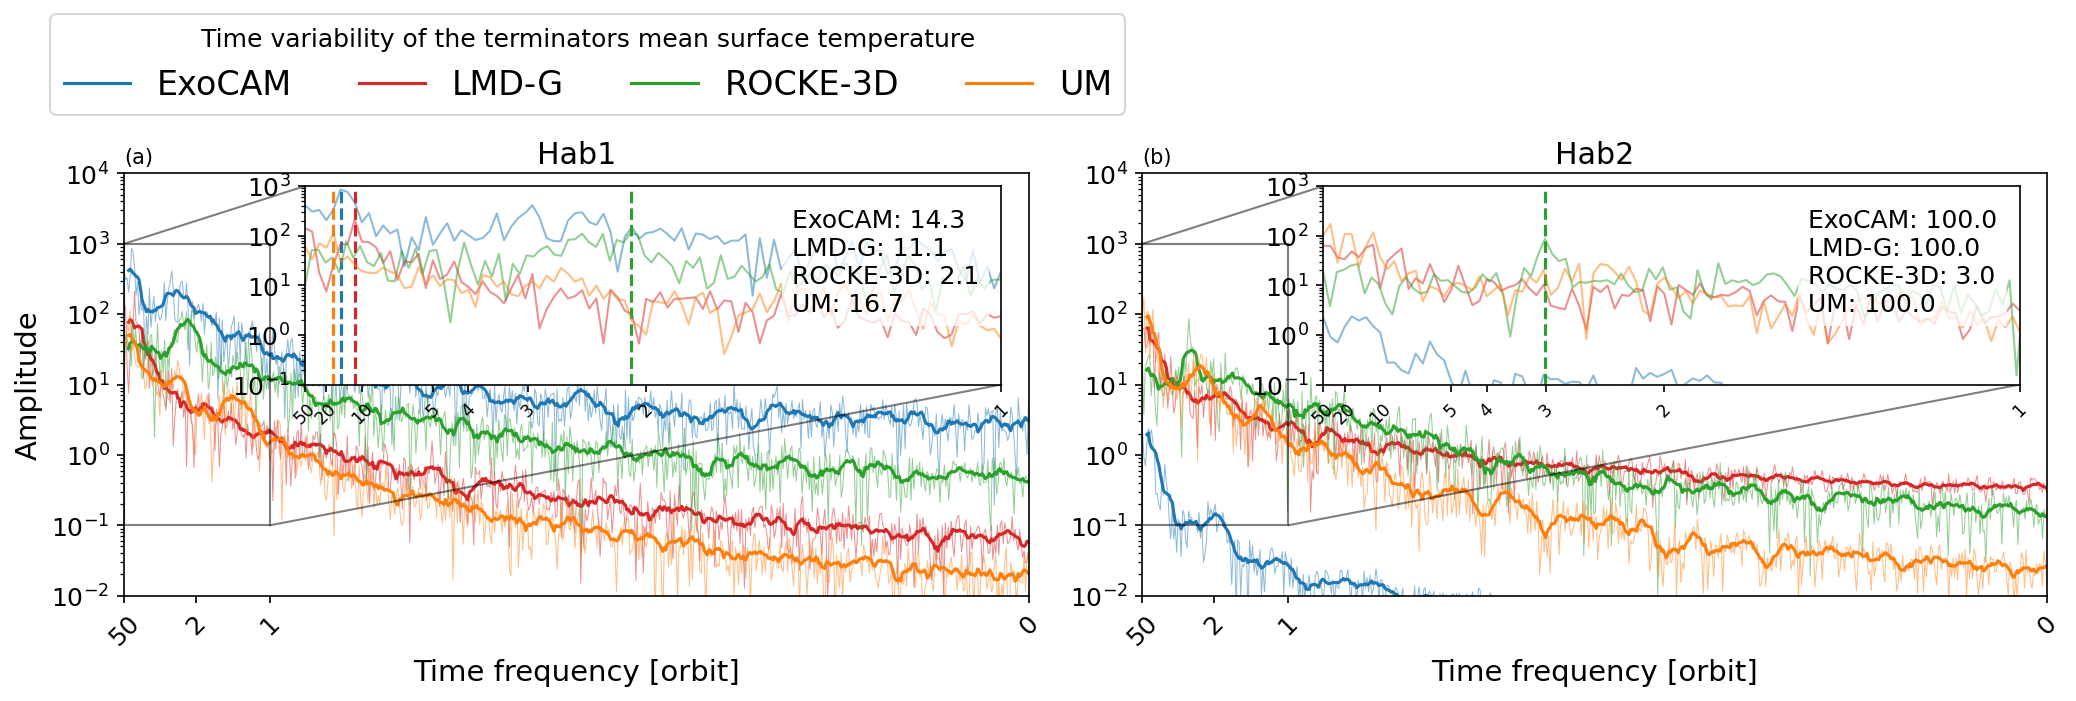

In [68]:
var_key = "t_sfc"
aggr_key = "t"
# var_key = "cwp"
# aggr_key = "t"
ncols = 2
nrows = 1

fig, axs = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(7 * ncols, 4 * nrows), constrained_layout=False
)
iletters = aplt.subplot_label_generator()

for THAI_case, parent_ax in zip(THAI_cases, axs):
    parent_ax.set_title(f"({next(iletters)})", **KW_SBPLT_LABEL)
    parent_ax.set_title(THAI_case, **KW_MAIN_TTL)
    parent_ax.set_xticks(
        1 / (periods_orbit * const.period),
    )
    parent_ax.set_xticklabels(np.int64(periods_orbit), rotation=45)
    parent_ax.set_xlim(
        1 / (periods_orbit[0] * const.period), 1 / (periods_orbit[-1] * const.period)
    )
    # parent_ax.set_ylim(0, 10)
    # parent_ax.set_yticks([])
    parent_ax.set_yscale("log")
    parent_ax.set_ylim(1e-2, 1e4)
    if parent_ax.get_subplotspec().is_last_row():
        parent_ax.set_xlabel("Time frequency [orbit]")
    if parent_ax.get_subplotspec().is_first_col():
        parent_ax.set_ylabel("Amplitude")

    axins = parent_ax.inset_axes([0.2, 0.5, 0.77, 0.47])
    axins.set_xticks(
        1 / (periods_orbit_lf * const.period),
    )
    axins.set_xticklabels(np.int64(np.round(periods_orbit_lf)), rotation=45, fontsize="x-small")
    axins.set_xlim(
        1 / (periods_orbit_lf[0] * const.period),
        1 / (periods_orbit_lf[-1] * const.period),
    )
    # axins.set_yticks([])
    # axins.set_ylim(0, 10)
    axins.set_ylim(1e-1, 1e3)
    axins.set_yscale("log")
    parent_ax.indicate_inset_zoom(axins, edgecolor="black")

    max_period_str = {}
    for model_key, model_dict in MODELS.items():
        model_names = names[model_key]
        vrbl = DATA_DICT[THAI_case][model_key][var_key][aggr_key]
        da = xr.DataArray(
            vrbl,
            dims=(model_names.t,),
            coords={model_names.t: np.arange(vrbl.shape[0]) / 4},
        )
        da_dft = xrft.dft(da, true_phase=True, true_amplitude=True, detrend="linear")
        da_dft_pos_half = abs(da_dft[da_dft.shape[0] // 2 :])
        max_period = 1 / da_dft_pos_half.idxmax()
        max_period_str[model_dict["title"]] = max_period / const.period

        parent_ax.plot(
            da_dft_pos_half[f"freq_{model_names.t}"],
            da_dft_pos_half,
            alpha=0.5,
            linewidth=0.5,
            color=model_dict["color"],
        )
        parent_ax.plot(
            da_dft_pos_half[f"freq_{model_names.t}"],
            da_dft_pos_half.rolling(
                **{f"freq_{model_names.t}": freq_roll_window}, center=True
            ).mean(),
            linewidth=1.5,
            color=model_dict["color"],
            label=model_dict["title"],
        )
        axins.plot(
            da_dft_pos_half[f"freq_{model_names.t}"],
            da_dft_pos_half,
            alpha=0.5,
            linewidth=1,
            color=model_dict["color"],
        )
        axins.axvline(1 / max_period, color=model_dict["color"], linestyle="--")
    max_period_str = "\n".join([f"{k}: {float(v.values):.1f}" for k, v in max_period_str.items()])
    at = AnchoredText(max_period_str, loc="upper right")
    at.patch.set_facecolor((1, 1, 1, 0.75))
    at.patch.set_edgecolor("none")
    axins.add_artist(at)
fig.tight_layout()
ttl = f"Time variability of the {AGGR_COLLECTION[aggr_key]['title'].lower()} mean {VAR_PLOT[var_key]['title'].split(' [$')[0].lower()}"
axs.flatten()[0].legend(title=ttl, ncol=len(MODELS), loc="lower left", bbox_to_anchor=(-0.1, 1.1))
# figsave(
#     fig,
#     mypaths.plotdir
#     / (
#         f"{'_'.join(THAI_cases)}__tfreq__{'_'.join(VAR_PLOT.keys())}"
#         f"_{AGGR_COLLECTION[aggr_key]['title'].replace(' ', '_').lower()}_mean_logscale"
#     ),
# )

## TESTING

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
SAMPLE_RATE = 44100  # Hertz
DURATION = 5  # Seconds

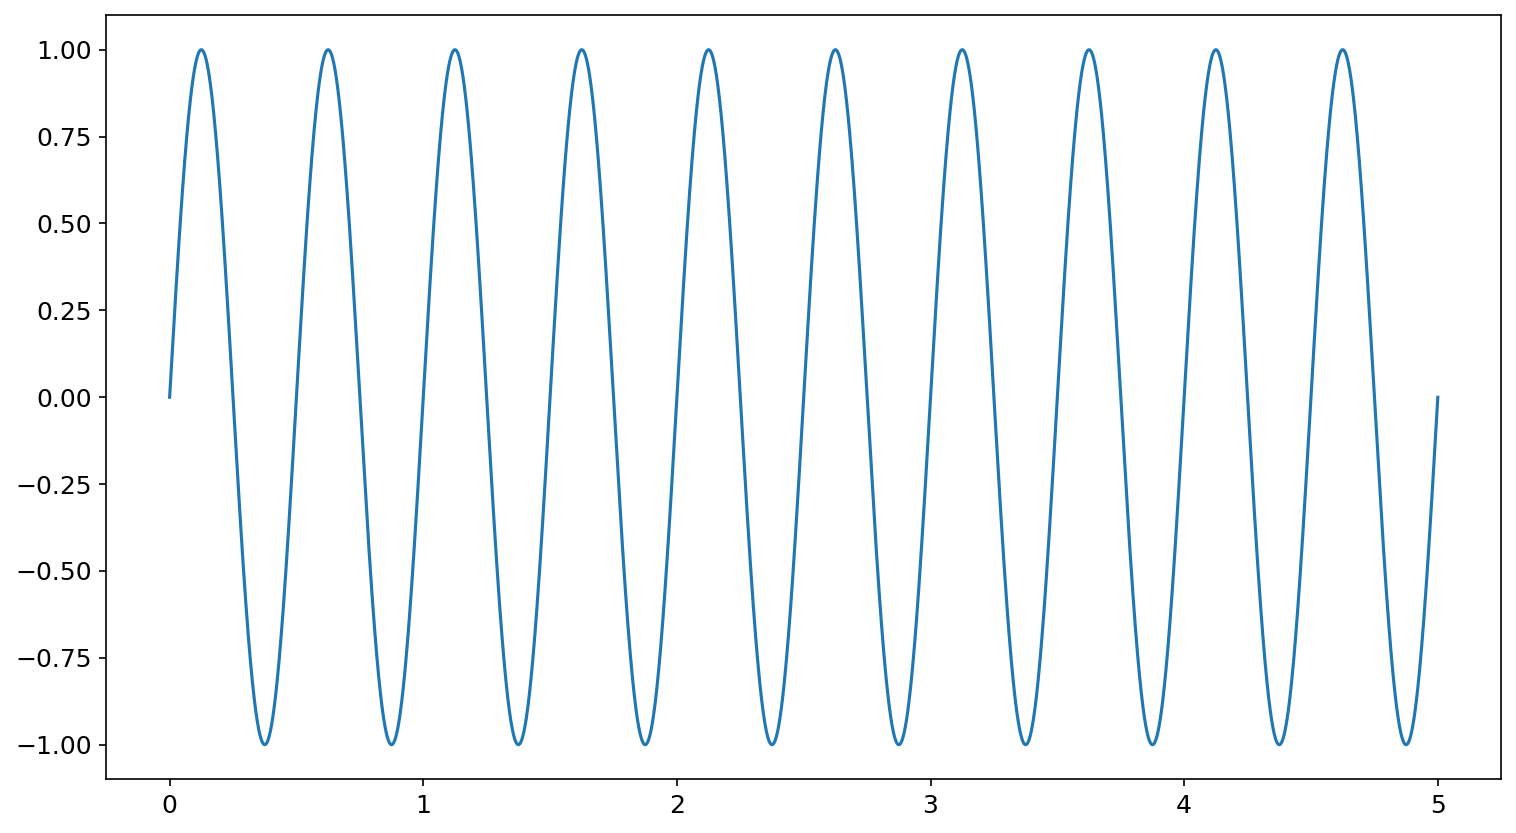

In [90]:
# Generate a 2 hertz sine wave that lasts for 5 seconds
x, y = generate_sine_wave(2, SAMPLE_RATE, DURATION)
plt.plot(x, y)

In [8]:
_, nice_tone = generate_sine_wave(400, SAMPLE_RATE, DURATION)
_, noise_tone = generate_sine_wave(4000, SAMPLE_RATE, DURATION)
noise_tone = noise_tone * 0.3

mixed_tone = nice_tone + noise_tone

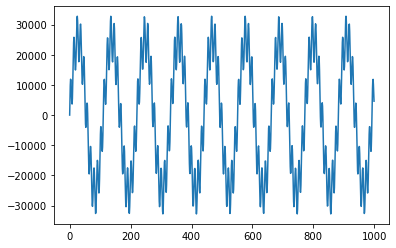

In [13]:
normalized_tone = np.int16((mixed_tone / mixed_tone.max()) * 32767)

plt.plot(normalized_tone[:1000])

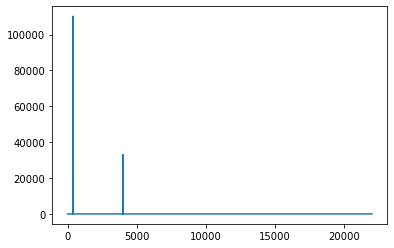

In [22]:
from scipy.fft import fft, fftfreq, rfft, rfftfreq

# Number of samples in normalized_tone
N = SAMPLE_RATE * DURATION

yf = rfft(mixed_tone)
xf = rfftfreq(N, 1 / SAMPLE_RATE)

plt.plot(xf, np.abs(yf))

In [18]:
N, mixed_tone.shape

(220500, (220500,))

In [19]:
SAMPLE_RATE

44100

In [20]:
DURATION

5

In [5]:
import xarray as xr
import xrft

In [6]:
DURATION = 610
SAMPLE_RATE = 4

In [8]:
def generate_sine_wave(freq, sample_rate, duration):
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = x * freq
    # 2pi because np.sin takes radians
    y = np.sin((2 * np.pi) * frequencies)
    return x, y

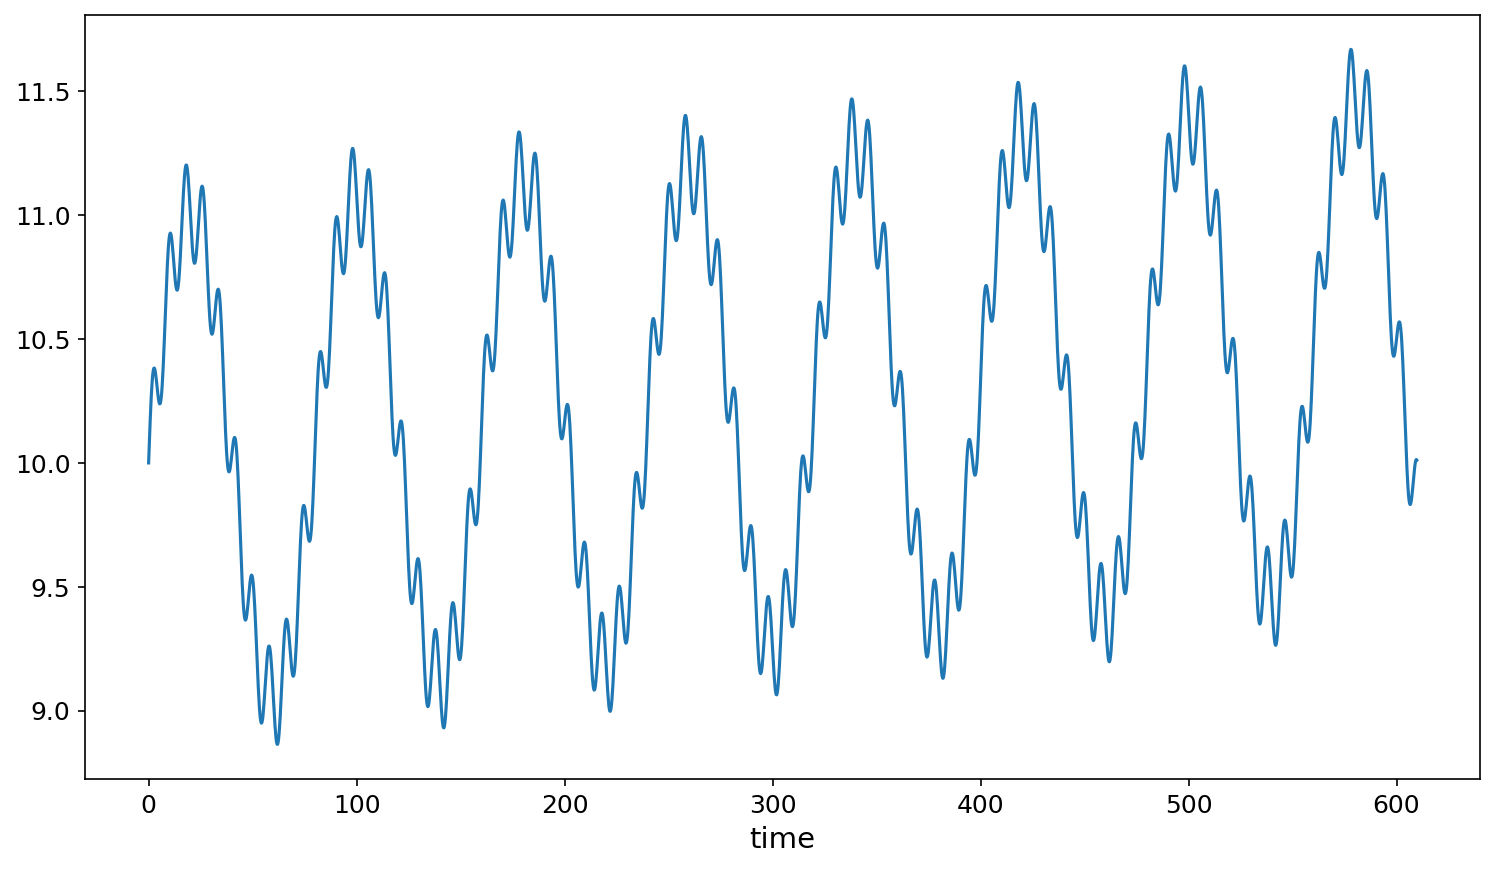

In [9]:
time_values, lf_wave = generate_sine_wave(1 / (20 * SAMPLE_RATE), SAMPLE_RATE, DURATION)
_, hf_wave = generate_sine_wave(1 / (2 * SAMPLE_RATE), SAMPLE_RATE, DURATION)
hf_wave = hf_wave * 0.2

dummy_data = lf_wave + hf_wave + time_values / 1200 + 10

da = xr.DataArray(dummy_data, dims=("time",), coords={"time": time_values})

da.plot()

In [13]:
da_dft = xrft.dft(da, true_phase=True, true_amplitude=True, detrend="linear")

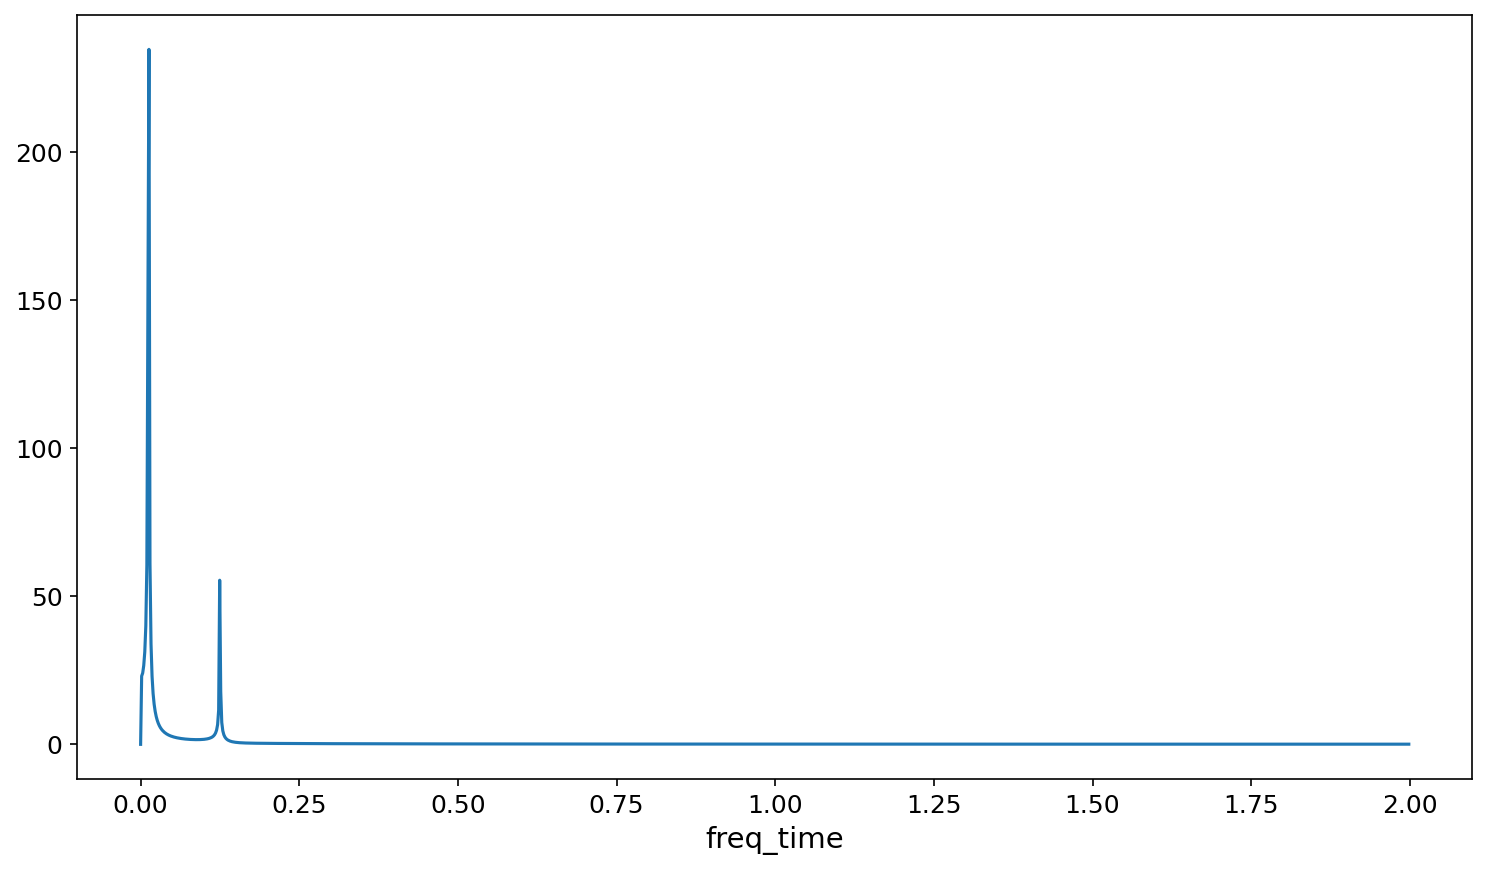

In [14]:
abs(da_dft[da_dft.shape[0] // 2 :]).plot()

In [15]:
a = abs(da_dft[da_dft.shape[0] // 2 :])

1 / a.idxmax()

<xarray.DataArray 'freq_time' ()>
array(76.25)